# ACTIVIDAD 2 - Implementación de filtro espacial o morfológico

Integrantes del grupo de trabajo:


* Alba Teixidó
* Mauricio Jurado
* Javier Blasco
* Javier Fernández

# Índice
[1. Preparación del entorno](#1)   
&nbsp;&nbsp;[1.1. Importación de librerías](#1.1)  
&nbsp;&nbsp;[1.2. Carga de imágenes](#1.2)  
[2. Tratamiento de las imágenes](#2)   
&nbsp;&nbsp;[2.1. Binarización](#2.1)  
&nbsp;&nbsp;[2.2. Operadores morfológicos](#2.2)  
&nbsp;&nbsp;[2.3. Filtro de mediana](#2.3)    
&nbsp;&nbsp;[2.4. Thinning](#2.4)    
&nbsp;&nbsp;&nbsp;&nbsp;[2.4.1. Definición kernels](#2.4.1)    
&nbsp;&nbsp;&nbsp;&nbsp;[2.4.2. Ejecución thinning](#2.4.2)    
&nbsp;&nbsp;[2.5. Hit or miss](#2.5)    
&nbsp;&nbsp;&nbsp;&nbsp;[2.5.1. Extracción terminaciones Ridge](#2.5.1)    
&nbsp;&nbsp;&nbsp;&nbsp;[2.5.2. Bifurcaciones Ridge](#2.5.2)    
[3. Solución final](#3) 


# 1. Preparación del entorno <a name="1"></a>

## 1.1. Importación de librerías <a name="1.1"></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import io, util, morphology
from scipy import ndimage as ndi
from skimage import img_as_float, img_as_ubyte

## 1.2. Carga de imágenes <a name="1.2"></a>

Leemos las imágenes y las pasamos a escala de grises

In [ ]:
img_1 = io.imread('finger1.png')
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)

img_2 = io.imread('finger3.png')
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

img_3 = io.imread('1.png')
img_3 = cv2.cvtColor(img_3, cv2.COLOR_BGR2GRAY)



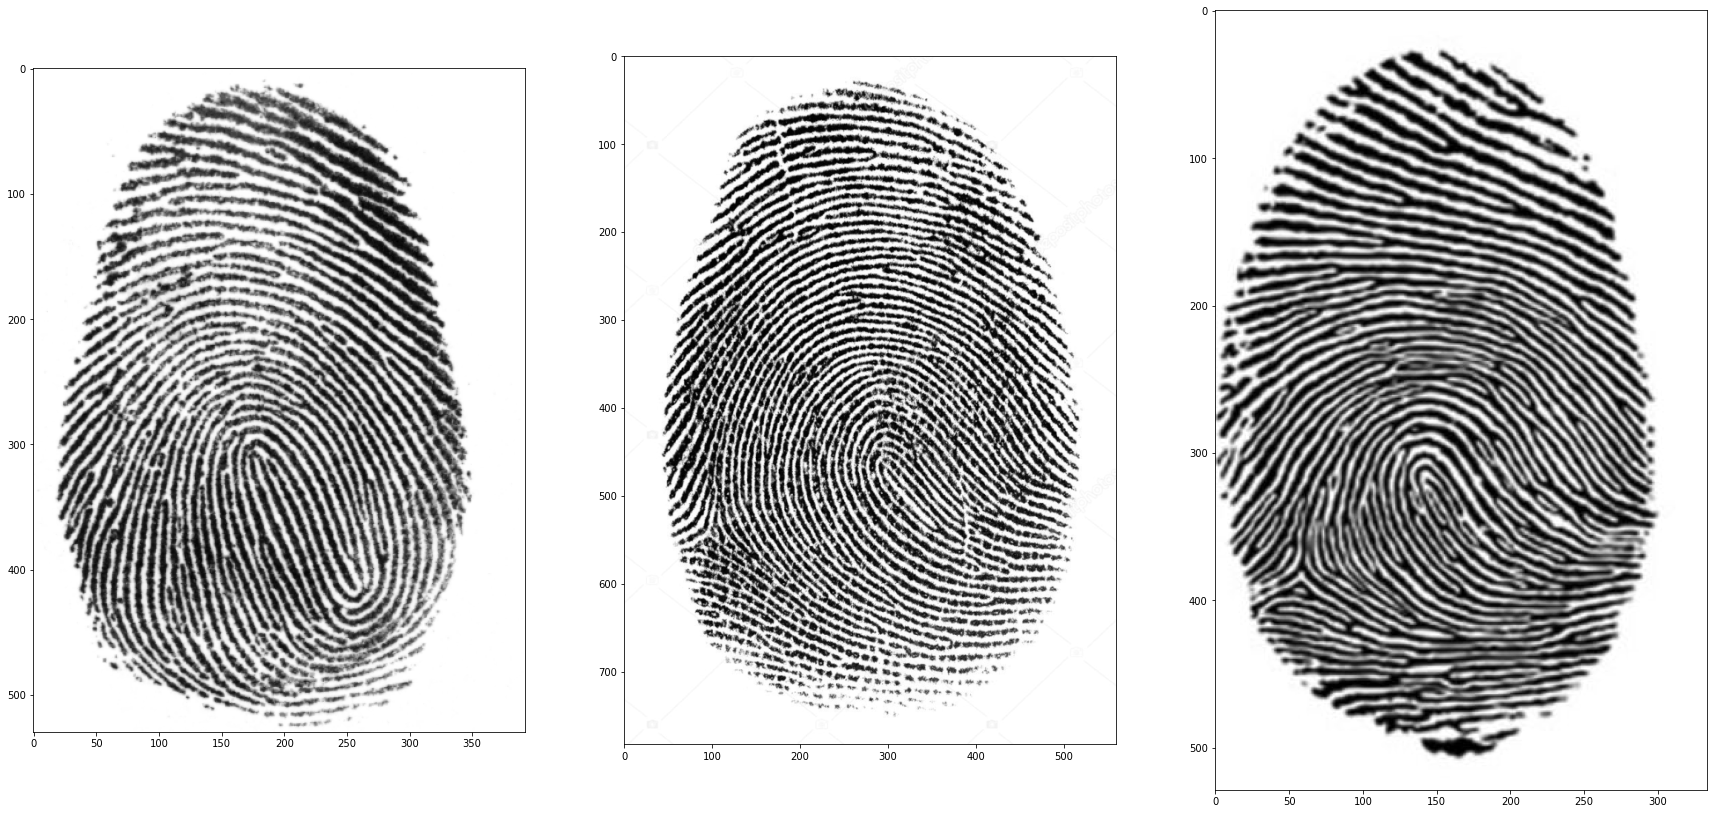

In [ ]:
f,(ax1,ax2, ax3)=plt.subplots(ncols=3,figsize=(30,15))

# primera hasta tercera
ax1.imshow(img_1,  cmap=plt.cm.gray)
ax2.imshow(img_2,  cmap=plt.cm.gray)
ax3.imshow(img_3,  cmap=plt.cm.gray)

# 2. Tratamiento de las imágenes <a name="2"></a>

## 2.1. Binarización <a name="2.1"></a>
En este apartado binarizaremos las imágenes buscando el threshold con la función *threshold finder* que es una función recursiva que calcula el threshold mediante la mediana hasta que converge

In [ ]:
def threshold_finder(img, thres=20,delta_T=0.5):
    
    x_low, y_low = np.where(img<=thres)
    x_high, y_high = np.where(img>thres)
    
    mean_low = np.mean(img[x_low,y_low])
    mean_high = np.mean(img[x_high,y_high])
    
    new_thres = (mean_low + mean_high)/2
    
    if abs(new_thres-thres)< delta_T:
        return new_thres
    else:
        return threshold_finder(img, thres=new_thres,delta_T=0.5)
    
def threshold(img, threshold):
    binary =  img >= threshold
    return binary

159.15568995663858
146.25984660537588
147.45043794896208


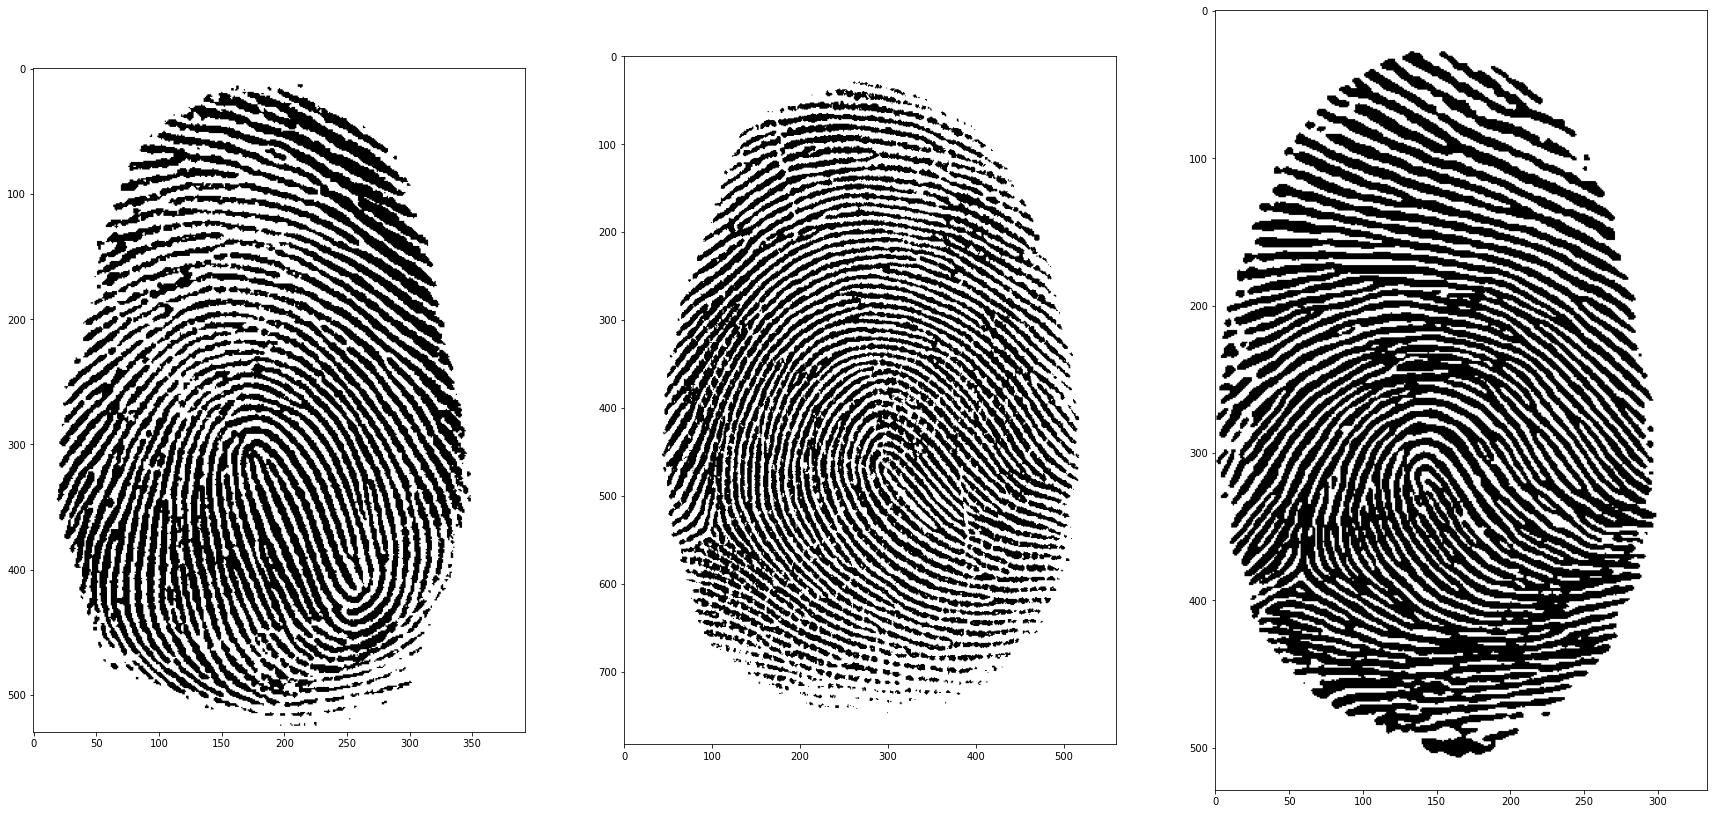

In [ ]:
print(threshold_1)
threshold_1 = threshold_finder(img_as_ubyte(img_1))
binary_1 = threshold(img_1, threshold_1)

print(threshold_2)
threshold_2 = threshold_finder(img_as_ubyte(img_2))
binary_2 = threshold(img_2, threshold_2)

threshold_3 = threshold_finder(img_as_ubyte(img_3))
print(threshold_3)
binary_3 = threshold(img_3, threshold_3)


f,(ax1,ax2, ax3)=plt.subplots(ncols=3,figsize=(30,15))

# primera hasta tercera
ax1.imshow(binary_1,  cmap=plt.cm.gray)
ax2.imshow(binary_2,  cmap=plt.cm.gray)
ax3.imshow(binary_3,  cmap=plt.cm.gray)

## 2.2. Operadores morfológicos <a name="2.2"></a>

En este apartado realizaremos correcciones para poder mejorar las imágenes quitando puntos blancos que se aprecian mediante primero una apertura con reconstrucción y después un filtro de mediana.


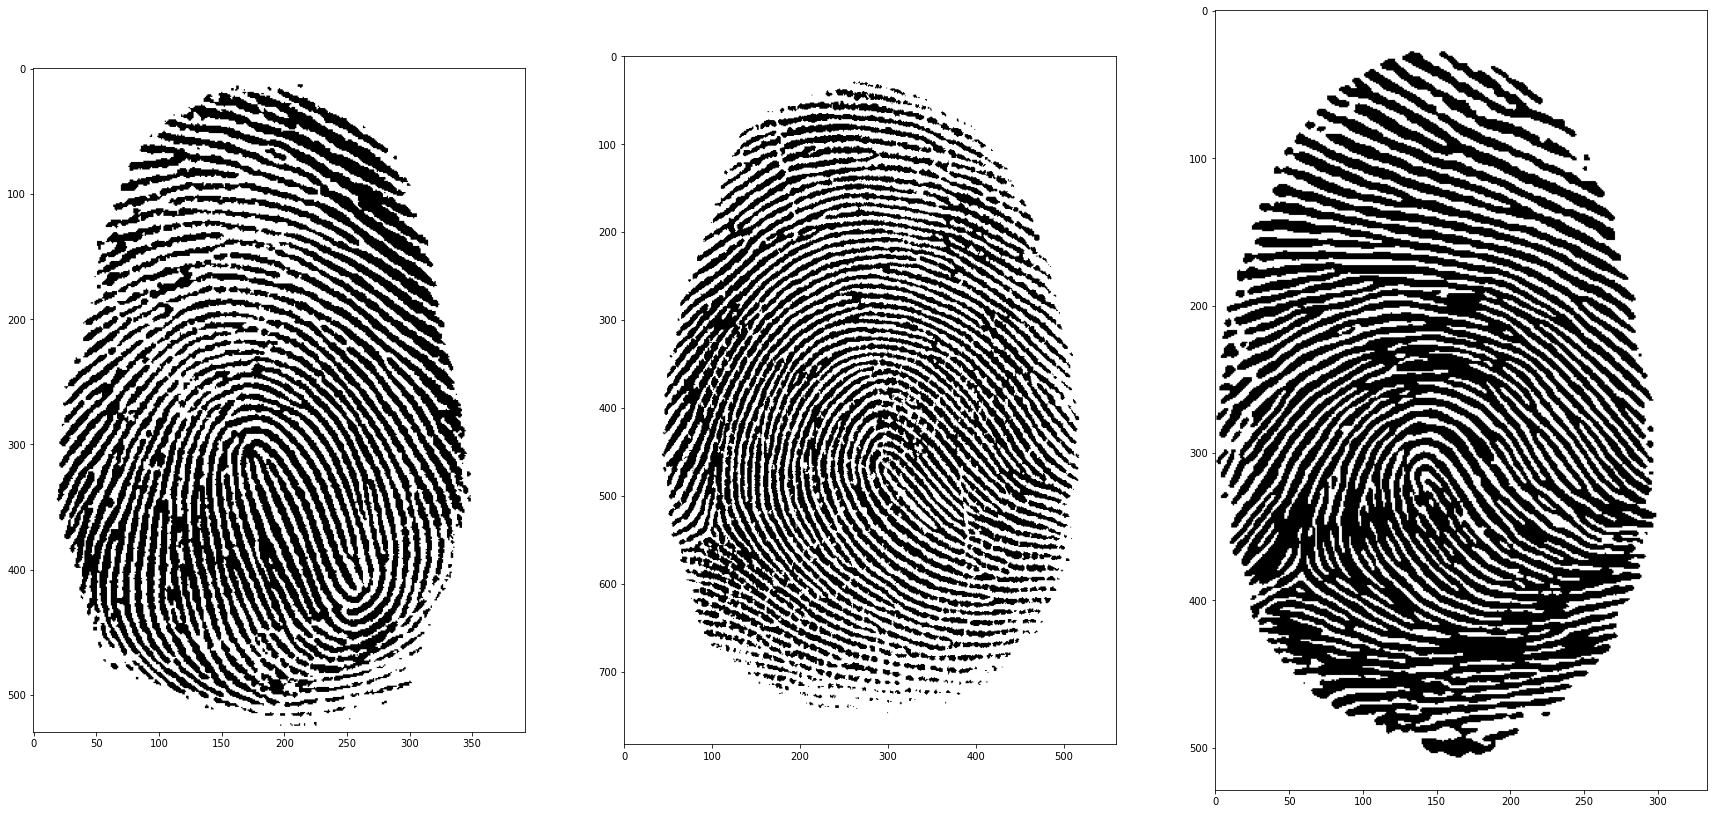

In [ ]:
kernel= np.array([ 
            [0, 1, 0], 
            [1, 1, 1], 
            [0, 1, 0]],np.uint8)

def apertura_reconstruccion(binary, kernel):
  A_0 = img_as_float(binary)
  A_1 = morphology.erosion(A_0,  kernel)
  done = False
  A_n = A_1
  while(not done):
      A_n_1 = morphology.dilation(A_n,  kernel)
      A_n_1 = cv2.bitwise_and(A_n_1, A_0)
      diff = cv2.bitwise_xor(A_n_1, A_n)
      A_n = A_n_1
      if(cv2.countNonZero(diff)==0):
          done = True
  return A_n

corrected_1 = apertura_reconstruccion(binary_1, kernel)
corrected_2 = apertura_reconstruccion(binary_2, kernel)
corrected_3 = apertura_reconstruccion(binary_3, kernel)

f,(ax1,ax2, ax3)=plt.subplots(ncols=3,figsize=(30,15))

# primera hasta tercera
ax1.imshow(corrected_1,  cmap=plt.cm.gray)
ax2.imshow(corrected_2,  cmap=plt.cm.gray)
ax3.imshow(corrected_3,  cmap=plt.cm.gray)


## 2.3. Filtro de mediana <a name="2.3"></a>
Se ha elegido el filtro de mediana frente al gaussian blur o bilateralFilter debido a que generaba una solución mejor.

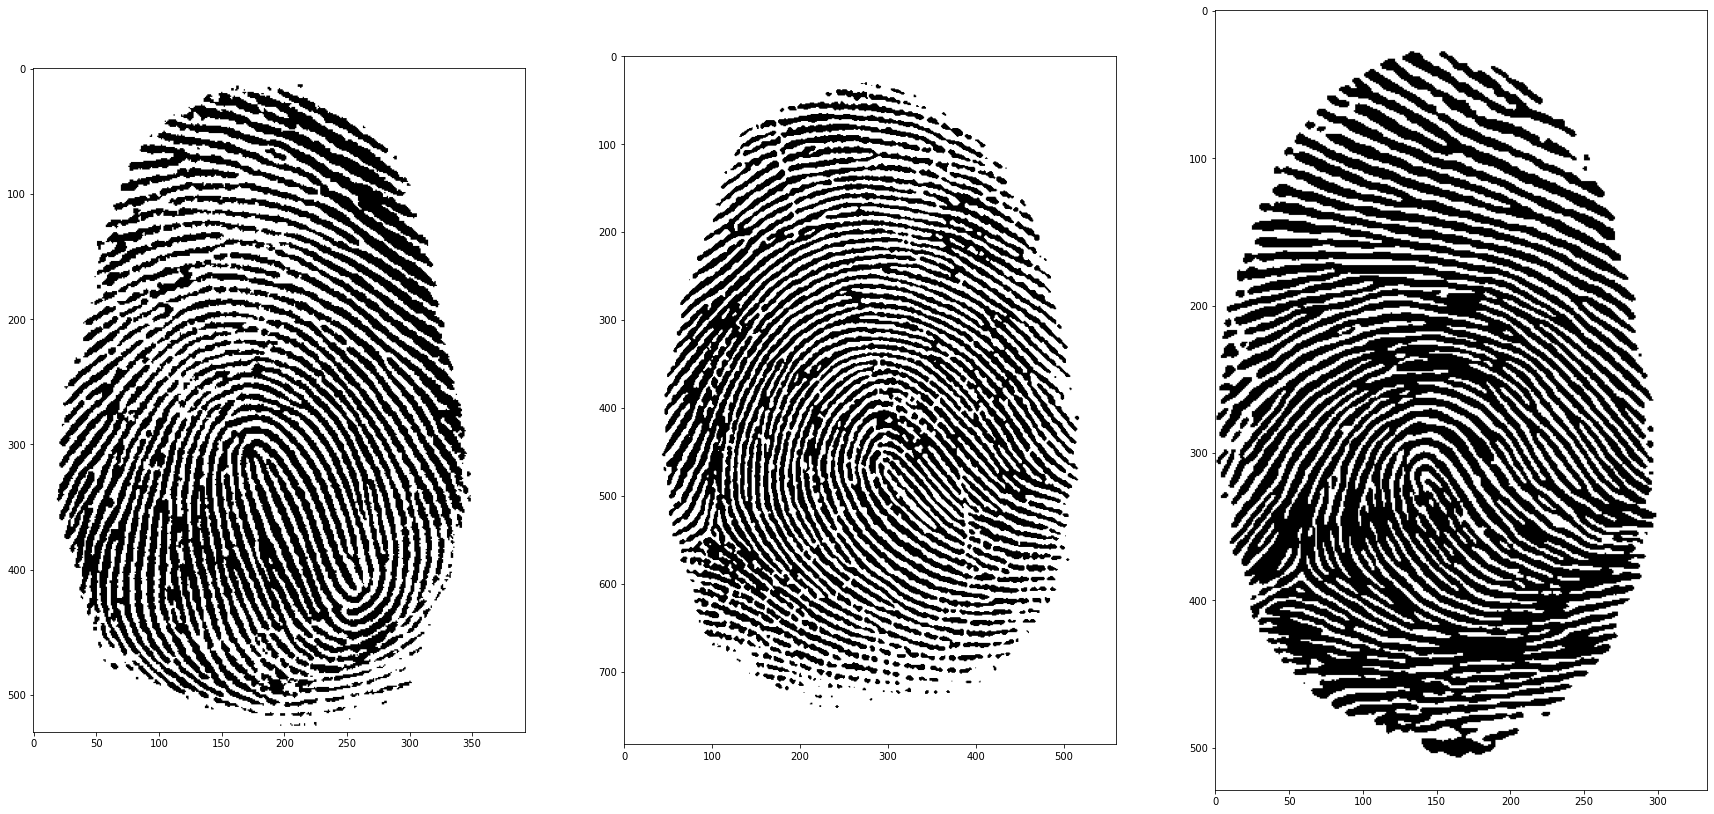

In [ ]:
# img_blur = cv2.bilateralFilter(img,9,75,75)
def filtro_mediana(img, ventana):
    k =  ventana // 2
    for y in range(k, img.shape[0]-k):
        for x in range(k, img.shape[1]-k):
            region = img[y-k:y+k+1, x-k:x+k+1]
            mediana = np.median(region)
            img[y,x] = mediana
    return img

filtro_1 = filtro_mediana(corrected_1, 1)
filtro_2 = filtro_mediana(corrected_2, 3)
filtro_3 = filtro_mediana(corrected_3, 1)

f,(ax1,ax2, ax3)=plt.subplots(ncols=3,figsize=(30,15))

ax1.imshow(filtro_1,  cmap=plt.cm.gray)
ax2.imshow(filtro_2,  cmap=plt.cm.gray)
ax3.imshow(filtro_3,  cmap=plt.cm.gray)


## 2.4. Thinning <a name="2.4"></a>



En este apartado "esquelenotizaremos" las imágenes para obtener la silueta aplicando la operación de hit or miss con los siguientes kernels.

En cada iteración se utilizan dos kernels opuestos (kernel 1, kernel 2, étc) como parámetro de la función hit or miss,y tras cada iteración con una pareja de kernels, se realiza la diferencia con la imagen original.

La operación de hit or miss consiste en una erosión en la imagen original, y después una erosión en la imágen complementaria. Tras ello, se realiza la diferencia entre ambas.

In [ ]:
def thinning(img, J_1, J_2):
  x_k = img_as_float(img)
  for i in range(len(J_1)):
      # Aplicamos la operacion hit or miss
      x_k_1 = hit_or_miss(x_k, J_1[i], J_2[i])
      # Thinning
      binar = cv2.bitwise_or(x_k, x_k_1)
      x_k = binar
  return x_k

### 2.4.1. Definición kernels <a name="2.4.1"></a>

In [ ]:
kernel_1 = np.array([[1, 1, 1], [1, 0, 1], [0, 0, 0]],np.uint8)
kernel_2 = np.array([[0, 0, 0], [0, 1, 0], [1, 1, 1]],np.uint8)
kernel_3 = np.array([[1, 1, 1], [0, 0, 1], [1, 0, 1]],np.uint8)
kernel_4 = np.array([[0, 0, 0], [1, 1, 0], [0, 1, 0]],np.uint8)
kernel_5 = np.array([[0, 1, 1], [0, 0, 1], [0, 1, 1]],np.uint8)
kernel_6 = np.array([[1, 0, 0], [1, 1, 0], [1, 0, 0]],np.uint8)
kernel_7 = np.array([[1, 0, 1], [0, 0, 1], [1, 1, 1]],np.uint8)
kernel_8 = np.array([[0, 1, 0], [1, 1, 0], [0, 0, 0]],np.uint8)
kernel_9 = np.array([[0, 0, 0], [1, 0, 1], [1, 1, 1]],np.uint8)
kernel_10 = np.array([[1, 1, 1], [0, 1, 0], [0, 0, 0]],np.uint8)
kernel_11 = np.array([[1, 0, 1], [1, 0, 0], [1, 1, 1]],np.uint8)
kernel_12 = np.array([[0, 1, 0], [0, 1, 1], [0, 0, 0]],np.uint8)
kernel_13 = np.array([[1, 1, 0], [1, 0, 0], [1, 1, 0]],np.uint8)
kernel_14 = np.array([[0, 0, 1], [0, 1, 1], [0, 0, 1]],np.uint8)
kernel_15 = np.array([[1, 1, 1], [1, 0, 0], [1, 0, 1]],np.uint8)
kernel_16 = np.array([[0, 0, 0], [0, 1, 1], [0, 1, 0]],np.uint8)
J_1 = [kernel_1, kernel_3, kernel_5, kernel_7, kernel_9, kernel_11, kernel_13, kernel_15]
J_2 = [kernel_2, kernel_4, kernel_6, kernel_8, kernel_10, kernel_12, kernel_14, kernel_16]


 ### 2.4.2. Ejecución Thinning <a name="2.4.2"></a>

In [ ]:
thinning_1 = thinning(filtro_1, J_1, J_2)

thinning_2 = thinning(filtro_2, J_1, J_2)

thinning_3 = thinning(filtro_3, J_1, J_2)



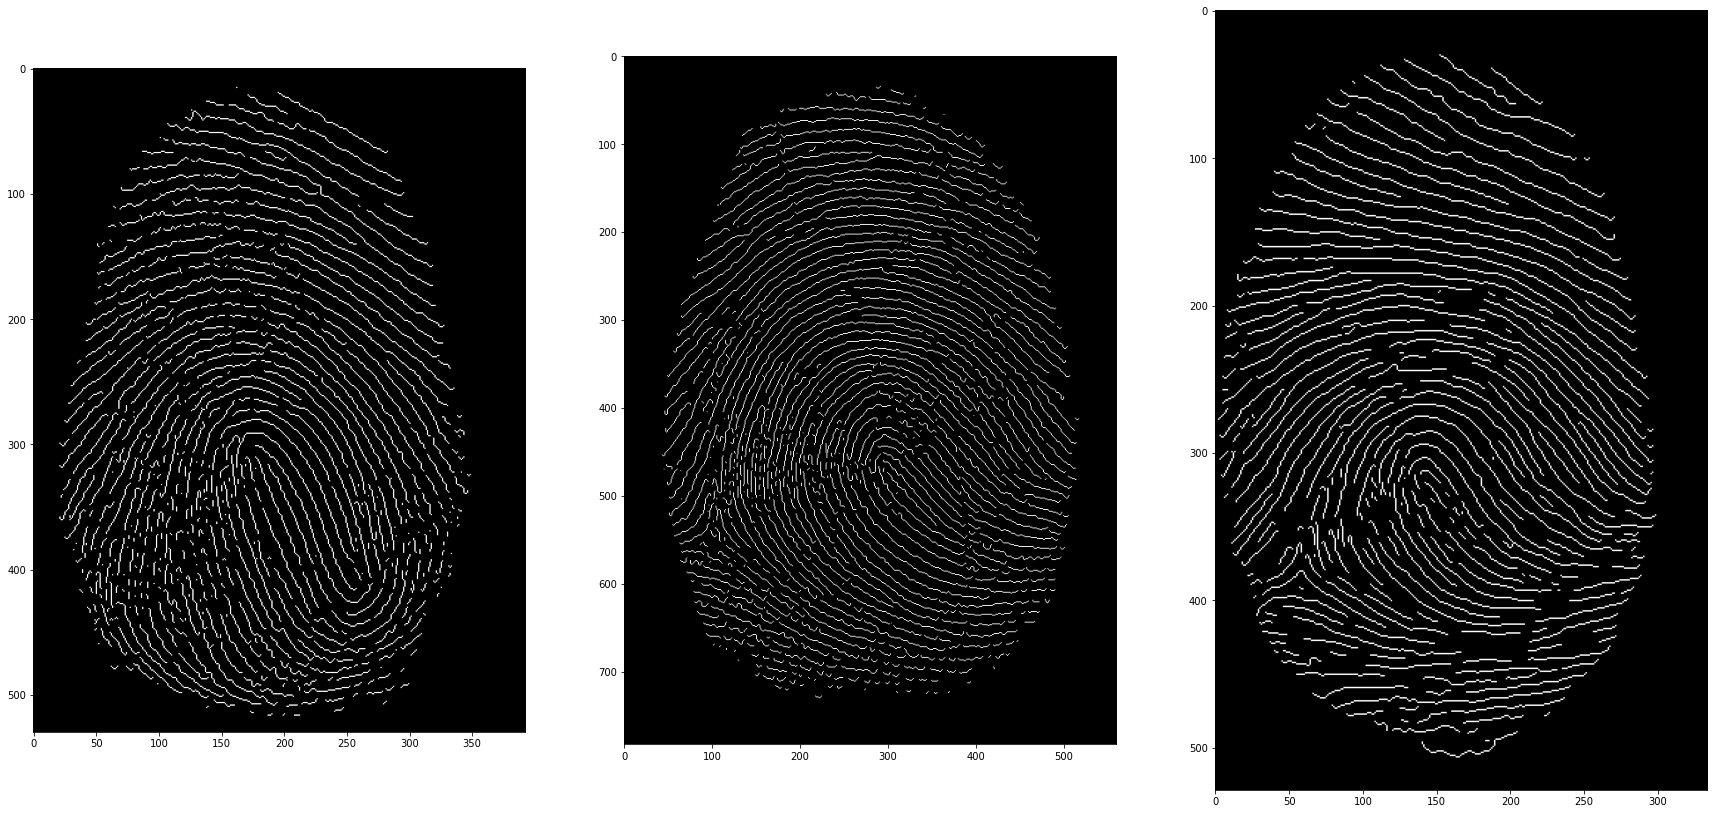

In [ ]:
f,(ax1,ax2, ax3)=plt.subplots(ncols=3,figsize=(30,15))

# primera hasta tercera
ax1.imshow(util.invert(thinning_1),  cmap=plt.cm.gray)
ax2.imshow(util.invert(thinning_2),  cmap=plt.cm.gray)
ax3.imshow(util.invert(thinning_3),  cmap=plt.cm.gray)

 ## 2.5. Hit or miss <a name="2.5"></a>

In [ ]:
def hit_or_miss(img, element_1, element_2):
    img = img_as_float(img)
    inverted_img = util.invert(img)
    eroded_img = cv2.erode(img,element_1)
    eroded_inverted_img = cv2.erode(inverted_img, element_2)
    result =  cv2.bitwise_or(eroded_img,eroded_inverted_img)
    return result

### 2.5.1. Extracción terminaciones Ridge <a name="2.5.1"></a> 

En este apartado se extraen las terminaciones de anillos mediante la operación hit or miss, variando los kernels utilizados en cada iteración

In [ ]:


j11 = np.array([[0,1,0], [0,1,0], [0, 0, 0]], np.uint8)
j12 = np.array([[0,0,0], [0,1,1], [0, 0, 0]], np.uint8)
j13 = np.array([[0,0,0], [0,1,0], [0, 1, 0]], np.uint8)
j14 = np.array([[0,0,0], [1,1,0], [0, 0, 0]], np.uint8)
j15 = np.array([[1,0,0], [0,1,0], [0, 0, 0]], np.uint8)
j16 = np.array([[0,0,1], [0,1,0], [0, 0, 0]], np.uint8)
j17 = np.array([[0,0,0], [0,1,0], [0, 0, 1]], np.uint8)
j18 = np.array([[0,0,0], [0,1,0], [1, 0, 0]], np.uint8)
j21 = np.array([[1,0,1], [1,0,1], [1, 1, 1]], np.uint8)
j22 = np.array([[1,1,1], [1,0,0], [1, 1, 1]], np.uint8)
j23 = np.array([[1,1,1], [1,0,1], [1, 0, 1]], np.uint8)
j24 = np.array([[1,1,1], [0,0,1], [1, 1, 1]], np.uint8)
j25 = np.array([[0,1,1], [1,0,1], [1, 1, 1]], np.uint8)
j26 = np.array([[1,1,0], [1,0,1], [1, 1, 1]], np.uint8)
j27 = np.array([[1,1,1], [1,0,1], [1, 1, 0]], np.uint8)
j28 = np.array([[1,1,1], [1,0,1], [0, 1, 1]], np.uint8)

J_1_t = [j11, j12, j13, j14, j15, j16, j17, j18]
J_2_t = [j21, j22, j23, j24, j25, j26, j27, j28]


def ridge_terminations(img, J_1, J_2):
  x_k = img_as_float(img)
  for i in range(len(J_1)):
      x_k_1 = hit_or_miss(x_k, J_1[i], J_2[i])
      x_k = x_k_1
  return x_k

In [ ]:
ridge_terminations_1 = ridge_terminations(thinning_1, J_1_t, J_2_t)
ridge_terminations_2 = ridge_terminations(thinning_2, J_1_t, J_2_t)
ridge_terminations_3 = ridge_terminations(thinning_3, J_1_t, J_2_t)

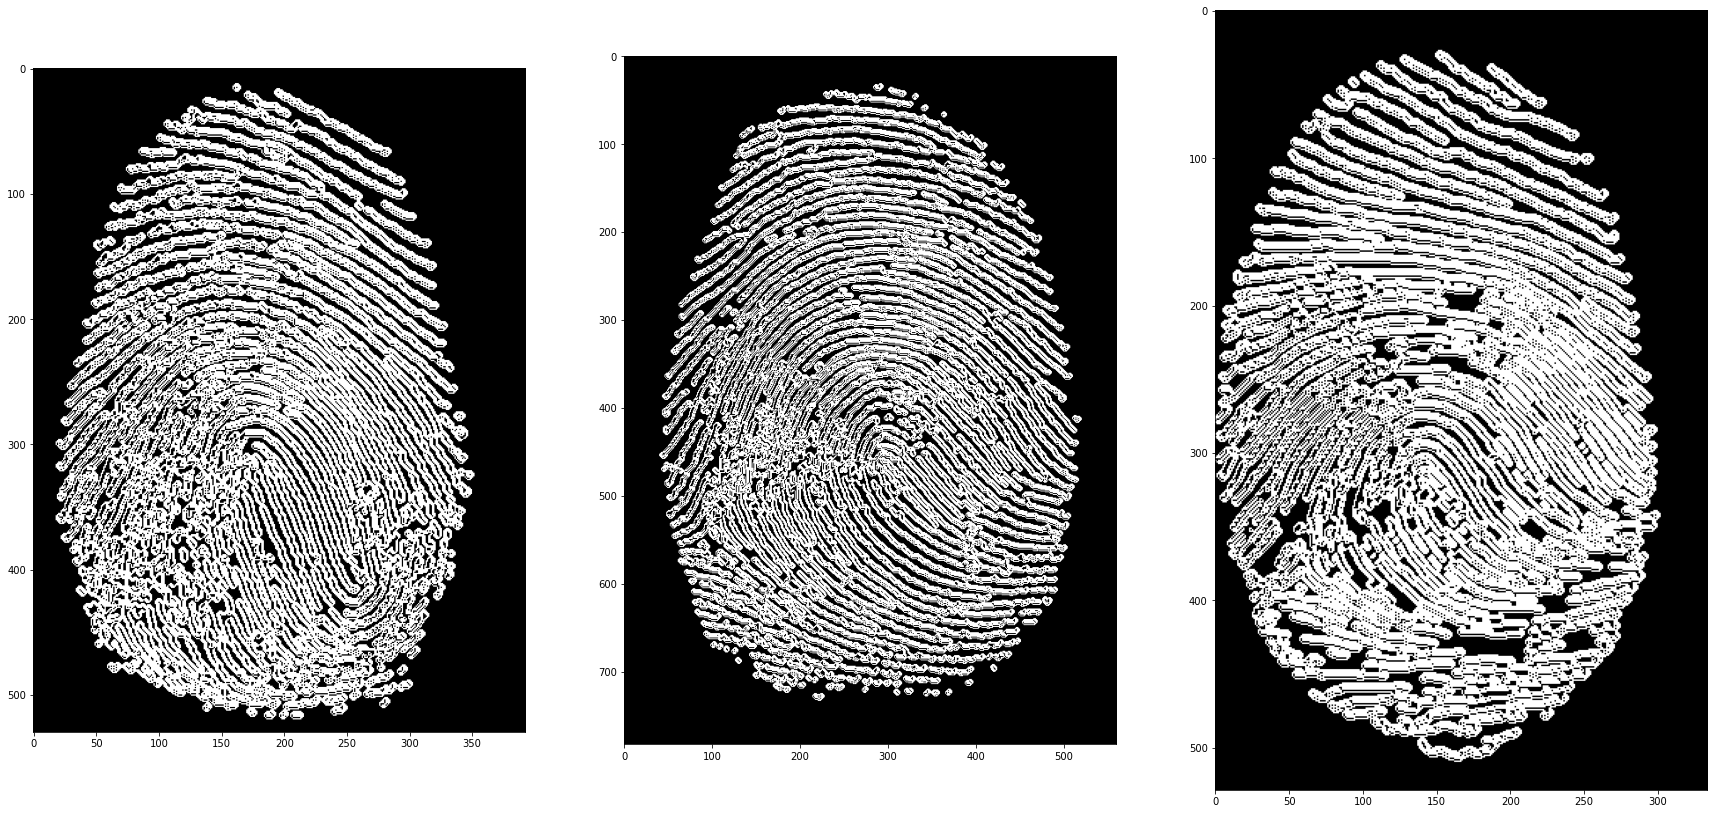

In [ ]:
f,(ax1,ax2, ax3)=plt.subplots(ncols=3,figsize=(30,15))

# primera hasta tercera
ax1.imshow(util.invert(ridge_terminations_1),  cmap=plt.cm.gray)
ax2.imshow(util.invert(ridge_terminations_2),  cmap=plt.cm.gray)
ax3.imshow(util.invert(ridge_terminations_3),  cmap=plt.cm.gray)

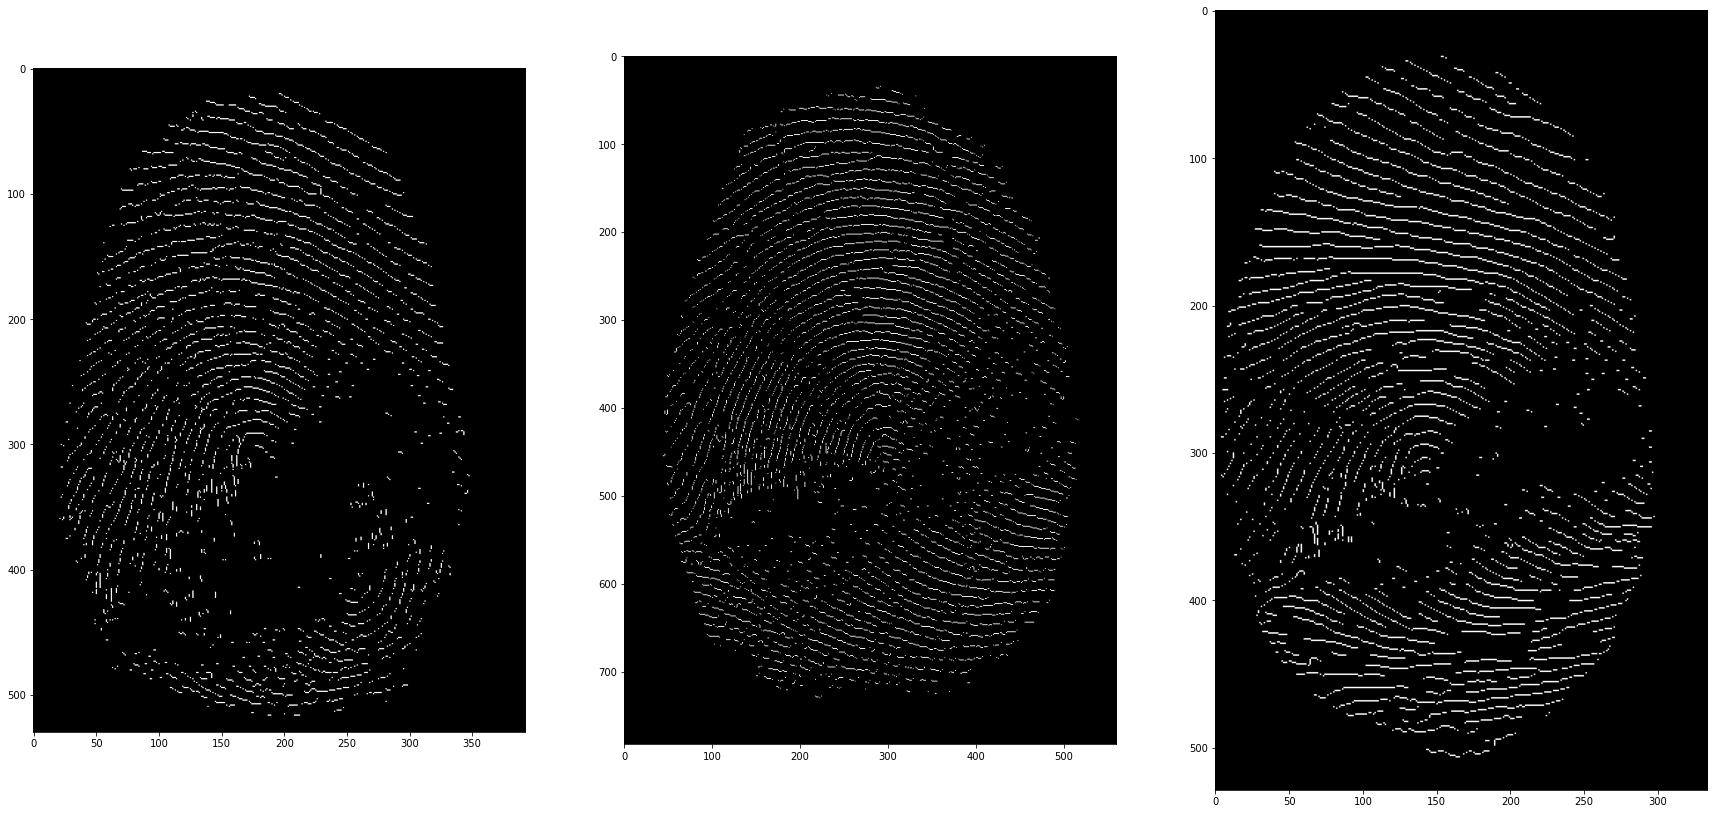

In [ ]:
res_1 = cv2.bitwise_or(thinning_1, ridge_terminations_1)
res_2 = cv2.bitwise_or(thinning_2, ridge_terminations_2)
res_3 = cv2.bitwise_or(thinning_3, ridge_terminations_3)

f,(ax1,ax2, ax3)=plt.subplots(ncols=3,figsize=(30,15))

# primera hasta tercera
ax1.imshow(util.invert(res_1),  cmap=plt.cm.gray)
ax2.imshow(util.invert(res_2) , cmap=plt.cm.gray)
ax3.imshow(util.invert(res_3),  cmap=plt.cm.gray)



 ### 2.5.2. Bifurcaciones Ridge <a name="2.5.2"></a> 

En este apartado se extraen las bifurcaciones de anillos mediante la operación hit or miss vriando los kernels en cada iteración

In [ ]:
strelements = []

j11 = np.array([[0,0,1], [1,1,0], [0, 0, 1]], np.uint8)
j12 = np.array([[0,1,0], [0,1,0], [1, 0, 1]], np.uint8)
j13 = np.array([[1,0,0], [0,1,1], [1, 0, 0]], np.uint8)
j14 = np.array([[1,0,1], [0,1,0], [0, 1, 0]], np.uint8)
j15 = np.array([[0,1,0], [0,1,1], [1, 0, 0]], np.uint8)
j16 = np.array([[1,0,0], [0,1,1], [0, 1, 0]], np.uint8)
j17 = np.array([[0,0,1], [1,1,0], [0, 1, 0]], np.uint8)
j18 = np.array([[0,1,0], [1,1,0], [0, 0, 1]], np.uint8)
j21 = np.array([[1,1,0], [0,0,1], [1, 1, 0]], np.uint8)
j22 = np.array([[1,0,1], [1,0,1], [0, 1, 0]], np.uint8)
j23 = np.array([[0,1,1], [1,0,0], [0, 1, 1]], np.uint8)
j24 = np.array([[0,1,0], [1,0,1], [1, 0, 1]], np.uint8)
j25 = np.array([[1,0,1], [1,0,0], [0, 1, 1]], np.uint8)
j26 = np.array([[0,1,1], [1,0,0], [0, 1, 1]], np.uint8)
j27 = np.array([[1,1,0], [0,0,1], [1, 0, 1]], np.uint8)
j28 = np.array([[1,0,1], [0,0,1], [1, 1, 0]], np.uint8)

J_1_b = [j11, j12, j13, j14, j15, j16, j17, j18]
J_2_b = [j21, j22, j23, j24, j25, j26, j27, j28]



def ridge_bifurcations(img, J_1, J_2):
  x_k = img_as_float(inver)

  for i in range(len(J_1)):
      x_k_1 = hit_or_miss(x_k, J_1[i], J_2[i])
      x_k = x_k_1
  return x_k

In [ ]:
ridge_bifurcations_1 = ridge_terminations(thinning_1, J_1_b, J_2_b)
ridge_bifurcations_2 = ridge_terminations(thinning_2, J_1_b, J_2_b)
ridge_bifurcations_3 = ridge_terminations(thinning_3, J_1_b, J_2_b)



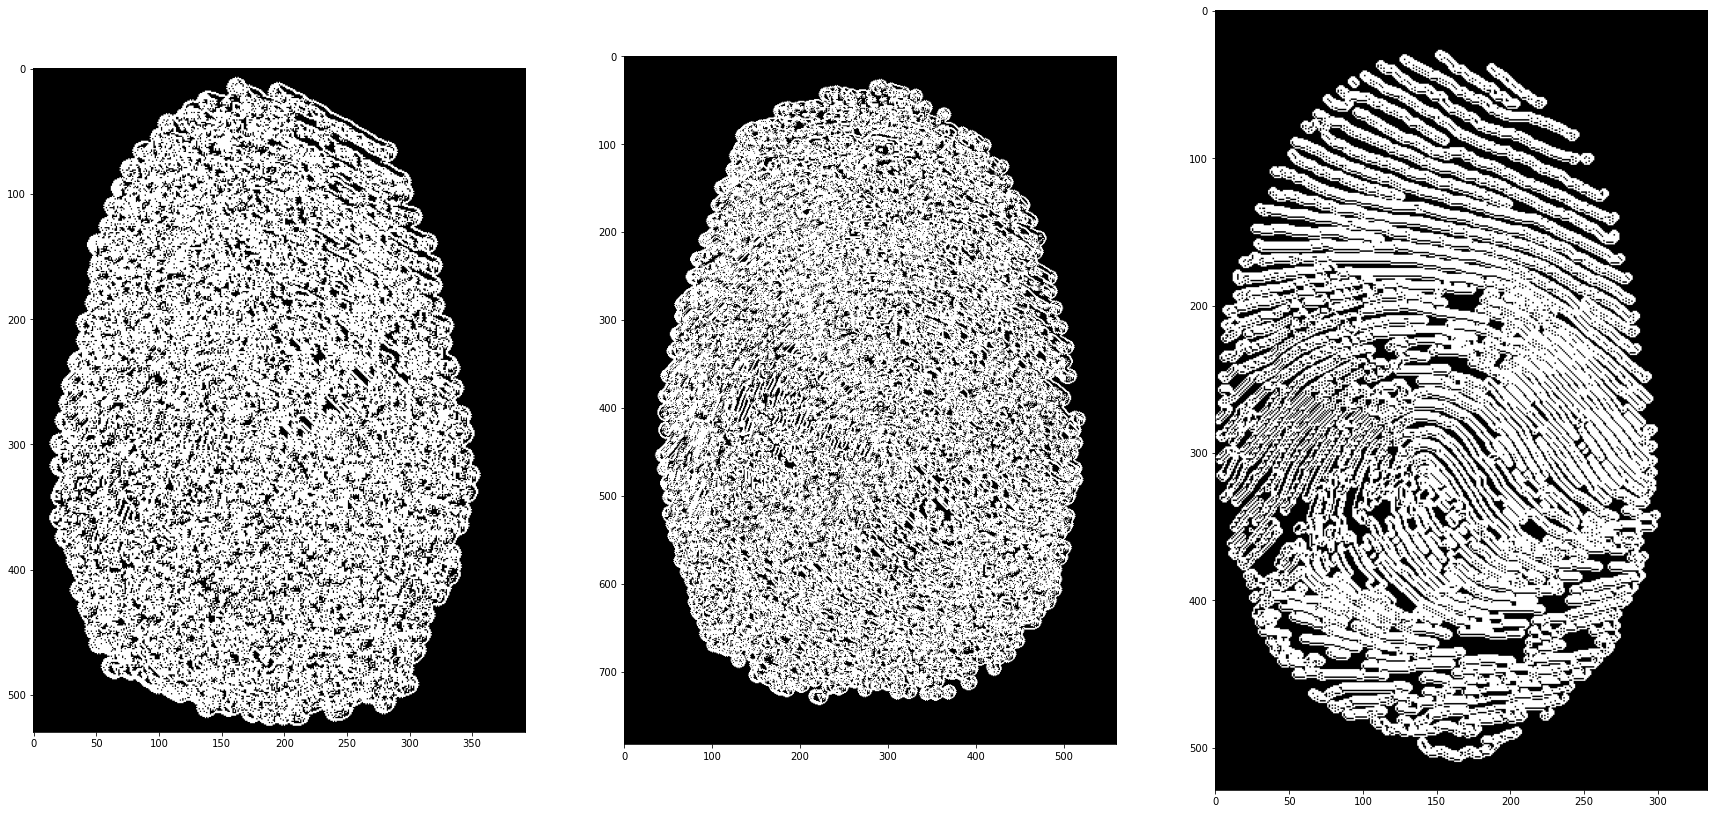

In [ ]:
f,(ax1,ax2, ax3)=plt.subplots(ncols=3,figsize=(30,15))

# primera hasta tercera
ax1.imshow(util.invert(ridge_bifurcations_1),  cmap=plt.cm.gray)
ax2.imshow(util.invert(ridge_bifurcations_2),  cmap=plt.cm.gray)
ax3.imshow(util.invert(ridge_terminations_3),  cmap=plt.cm.gray)

# 3. Solución final <a name="3"></a> 

Añadimos un filtro bitwise_or entre la solución de la función thinning y las bifurcaciones de Ridge para encontrar la solución final, que presentamos con colores invertidos para obtener una mejor visualización de la solución

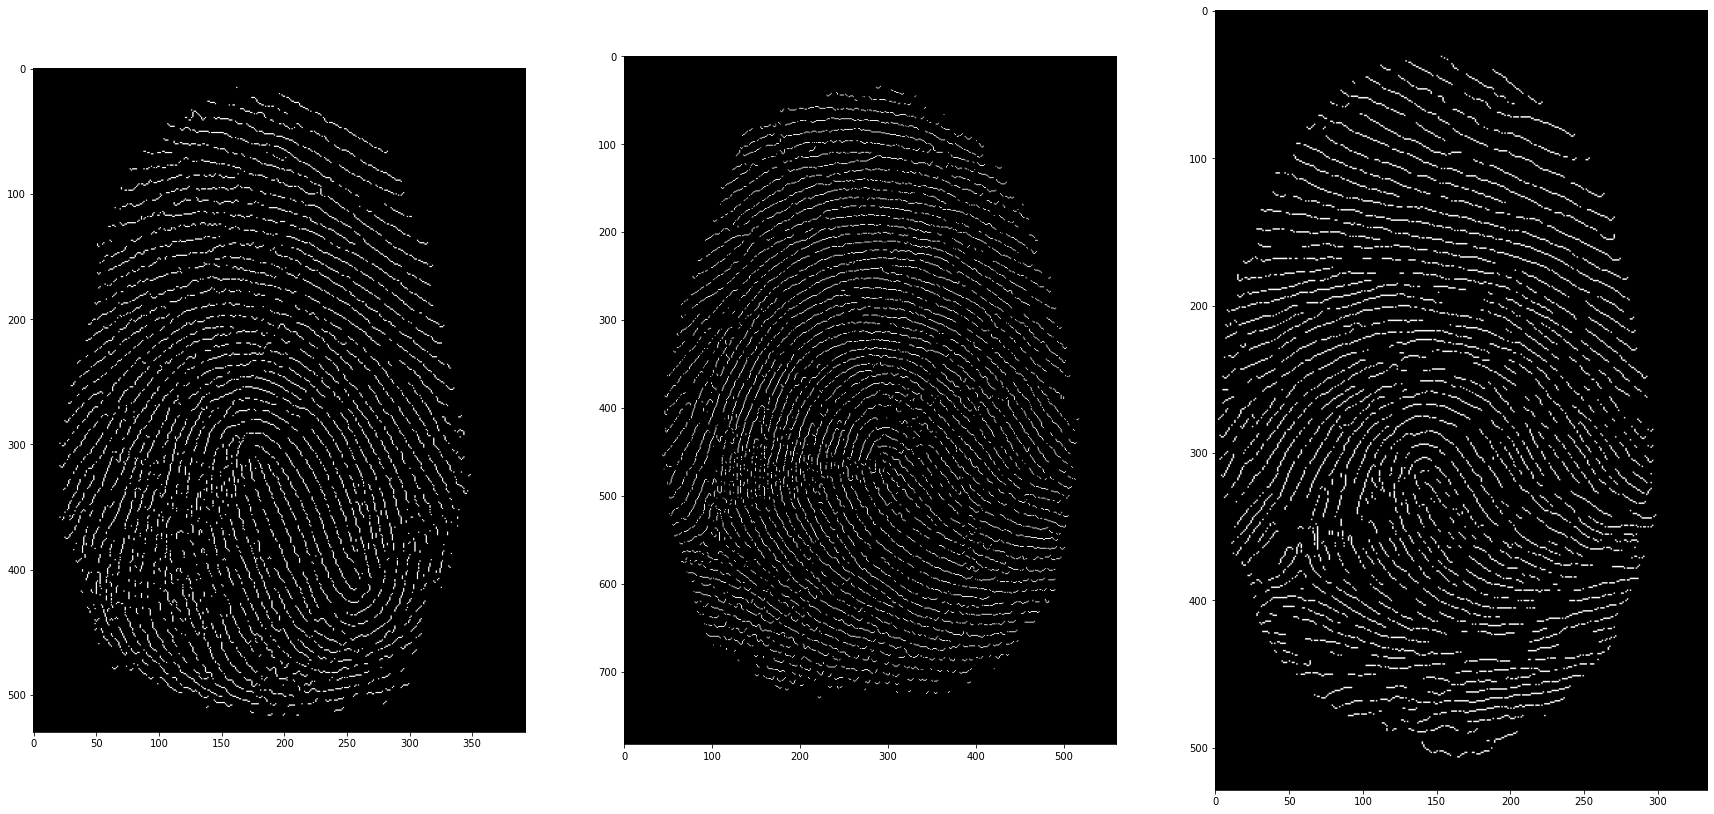

In [ ]:
res_1 = cv2.bitwise_or(thinning_1, ridge_bifurcations_1)
res_2 = cv2.bitwise_or(thinning_2, ridge_bifurcations_2)
res_3 = cv2.bitwise_or(thinning_3, ridge_bifurcations_3)

f,(ax1,ax2, ax3)=plt.subplots(ncols=3,figsize=(30,15))

# primera hasta tercera
ax1.imshow(util.invert(res_1),  cmap=plt.cm.gray)
ax2.imshow(util.invert(res_2) , cmap=plt.cm.gray)
ax3.imshow(util.invert(res_3),  cmap=plt.cm.gray)